# GPT - TRANING FROM SCRATCH - TRAIN TỪ ĐẦU

In [ ]:
import matplotlib.pyplot as plt


models = ['Transformer Scratch', 'BART-base', 'GPT Scratch', 'GPT2 Pretrained']
ppl = [121.83, 91.2, 89.91, 214.0]
logppl = [4.8026, 4.5274, 4.4988, 5.3660]
bleu_scores = [0.14, 0.03, 2.46, 5.36]
rouge_scores = [5.72, 0.23, 12.88, 15.75]

In [1]:
!pip install --quiet datasets
!pip install --quiet evaluate
!pip install --quiet rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

# Import thư viện và lấy dts

In [ ]:
import os, re, math, random, copy
import torch, torch.nn as nn, torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from tokenizers import ByteLevelBPETokenizer
from transformers import PreTrainedTokenizerFast
import evaluate

In [ ]:
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
ARTIFACT = "artifacts_gpt_scratch"
os.makedirs(ARTIFACT, exist_ok=True)

ds = load_dataset("RafaelMPereira/HealthCareMagic-100k-Chat-Format-en")["train"]
def split_QA(ds, max_samples=None):
    Q, A = [], []
    for ex in ds:
        t = ex["text"]
        if "<human>:" in t and "<bot>:" in t:
            _,_,h = t.partition("<human>:")
            h,_,b = h.partition("<bot>:")
            Q.append(h.strip())
            A.append(re.sub(r"(?i)LƯU Ý.*$","",b).strip())
            if max_samples and len(Q)>=max_samples: break
    return Q, A

questions, answers = split_QA(ds, max_samples=None)
tr_q, te_q, tr_a, te_a = train_test_split(questions, answers, test_size=0.1, random_state=42)
tr_q, va_q, tr_a, va_a = train_test_split(tr_q, tr_a, test_size=0.1111, random_state=42)

In [ ]:
#FPE
tok_dir = os.path.join(ARTIFACT, "bpe_tok")
if not os.path.isdir(tok_dir):
    bpe = ByteLevelBPETokenizer()
    bpe.train_from_iterator(tr_q+tr_a, vocab_size=30_000, min_frequency=2,
                            special_tokens=["<pad>","<s>","</s>","<unk>"])
    tokenizer = PreTrainedTokenizerFast(tokenizer_object=bpe)
    tokenizer.add_special_tokens({
        "pad_token":"<pad>","bos_token":"<s>",
        "eos_token":"</s>","unk_token":"<unk>"
    })
    tokenizer.save_pretrained(tok_dir)
else:
    tokenizer = PreTrainedTokenizerFast.from_pretrained(tok_dir)

vocab_size  = tokenizer.vocab_size
pad_id      = tokenizer.pad_token_id
bos_id      = tokenizer.bos_token_id
eos_id      = tokenizer.eos_token_id

# Lớp Dataset

In [ ]:
# 3) DATASET & COLLATE
class GPTDataset(Dataset):
    def __init__(self, qs, as_, tok, max_len=256):
        self.q, self.a, self.tok, self.L = qs, as_, tok, max_len
    def __len__(self):
      return len(self.q)

    def __getitem__(self, i):
        prompt=f"Patient: {self.q[i]}\nDoctor:"
        text=f"{prompt} {self.a[i]}"
        ids =self.tok.encode(text, add_special_tokens=False)[: self.L-2]
        inp=torch.tensor([bos_id] + ids + [eos_id], dtype=torch.long)
        lab=inp.clone()
        pre_len = len(self.tok.encode(prompt, add_special_tokens=False)) + 1
        lab[:pre_len] = -100
        return inp, lab

def collate(batch):
    x,y=zip(*batch)
    x=pad_sequence(x,batch_first=True,padding_value=pad_id)
    y=pad_sequence(y,batch_first=True,padding_value=-100)
    return x.to(DEVICE), y.to(DEVICE)

train_loader=DataLoader(GPTDataset(tr_q,tr_a,tokenizer),batch_size=32, shuffle=True,  collate_fn=collate)
val_loader=DataLoader(GPTDataset(va_q,va_a,tokenizer),batch_size=32, shuffle=False, collate_fn=collate)
test_loader=DataLoader(GPTDataset(te_q,te_a,tokenizer),batch_size=32, shuffle=False, collate_fn=collate)

# GPT

In [ ]:
def clones(m, N):
  return nn.ModuleList([copy.deepcopy(m) for _ in range(N)])

class GPTEmbedding(nn.Module):
    def __init__(self, V, d, max_len):
        super().__init__()
        self.tok=nn.Embedding(V, d, padding_idx=pad_id)
        self.pos=nn.Embedding(max_len, d)
        self.d=d

    def forward(self,x):
        B,T=x.shape
        pos=torch.arange(T, device=x.device)
        return self.tok(x)*math.sqrt(self.d)+self.pos(pos)

class MHA(nn.Module):
    def __init__(self, d, h, drop):
        super().__init__()
        assert d%h==0
        self.dk, self.h = d//h, h
        self.proj=nn.Linear(d, 3*d)
        self.o=nn.Linear(d, d)
        self.drop= nn.Dropout(drop)

    def forward(self,x,mask):
        B,T,C=x.size()
        q,k,v=self.proj(x).chunk(3, dim=-1)
        q,k,v=[t.view(B,T,self.h,self.dk).transpose(1,2) for t in (q,k,v)]
        att=(q @ k.transpose(-2,-1)) / math.sqrt(self.dk)
        att=att.masked_fill(mask[:T, :T], float("-inf"))
        att=self.drop(F.softmax(att, dim=-1))
        out=(att @ v).transpose(1,2).contiguous().view(B,T,C)
        return self.o(out)

class FFN(nn.Module):
    def __init__(self,d,dff,drop):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d,dff),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(dff,d),
            nn.Dropout(drop)
        )

    def forward(self,x):
      return self.net(x)

class GPTBlock(nn.Module):
    def __init__(self,d,h,dff,drop):
        super().__init__()
        self.ln1
        self.ln2 = nn.LayerNorm(d)
        nn.LayerNorm(d)
        self.attn = MHA(d,h,drop)
        self.ff=FFN(d,dff,drop)

    def forward(self,x,mask):
        x=x+self.attn(self.ln1(x),mask)
        x=x+self.ff(self.ln2(x))
        return x


# GPT
class GPTModel(nn.Module):
    def __init__(self,V,d=512,h=8,L=6,dff=2048,max_len=512,drop=0.1):
        super().__init__()
        self.emb=GPTEmbedding(V,d,max_len)
        self.blocks=clones(GPTBlock(d,h,dff,drop),L)
        self.ln_f=nn.LayerNorm(d)
        self.head=nn.Linear(d,V,bias=False)
        self.head.weight=self.emb.tok.weight
        self.register_buffer("mask",
                             torch.triu(torch.ones(max_len,max_len,
                                                   dtype=torch.bool),1))

    def forward(self,x):
        x=self.emb(x)
        for blk in self.blocks:
          x=blk(x, self.mask)
        return self.head(self.ln_f(x))

model = GPTModel(vocab_size).to(DEVICE)

In [ ]:
# OPTIMIZER và SCHEDULER
class NoamOpt:
    def __init__(self,d,factor,warm,optim):
        self.opt, self.d, self.f, self.w, self.n = optim,d,factor,warm,0
    def step(self):
        self.n += 1
        lr = self.f*(self.d**-0.5)*min(self.n**-0.5, self.n*(self.w**-1.5))
        for g in self.opt.param_groups: g['lr'] = lr
        self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

criterion = nn.CrossEntropyLoss(ignore_index=-100)
base_opt  = torch.optim.Adam(model.parameters(), betas=(0.9,0.98), eps=1e-9)
optimizer = NoamOpt(d=512, factor=1, warm=4000, optim=base_opt)

---

# TRAIN

In [1]:
best_val,patience,wait=float("inf"), 3, 0
for ep in range(1,6):
    model.train()
    tr_loss,tr_tokens= 0.0, 0
    for inp, lab in train_loader:
        optimizer.zero_grad()
        logits=model(inp)
        lm_logits= logits[:, :-1, :]
        lm_labels=lab[:, 1:]

        loss= criterion(
            lm_logits.reshape(-1, vocab_size),
            lm_labels.reshape(-1)
        )
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()

        nonpad=(lm_labels != -100).sum().item()
        tr_loss+= loss.item() * nonpad
        tr_tokens+= nonpad

    avg_tr=tr_loss/tr_tokens

    model.eval()
    val_loss, val_tokens = 0.0, 0
    with torch.no_grad():
        for inp, lab in val_loader:
            logits= model(inp)
            lm_logits=logits[:, :-1, :]
            lm_labels=lab[:, 1:]
            loss=criterion(
                lm_logits.reshape(-1, vocab_size),
                lm_labels.reshape(-1)
            )
            nonpad=(lm_labels != -100).sum().item()
            val_loss+=loss.item() * nonpad
            val_tokens+=nonpad

    avg_val = val_loss / val_tokens
    print(f"Epoch {ep} | Train loss={avg_tr:.4f} | Val loss={avg_val:.4f}")

    if avg_val<best_val:
        best_val,wait=avg_val, 0
        torch.save(model.state_dict(), os.path.join(ARTIFACT,"gpt_scratch_best.pt"))
    else:
        wait+=1
        if wait>=patience:
            print("Early stopping")
            break

---

# TEST

In [ ]:
@torch.no_grad()
def gpt_generate(question, max_new=128):
    prompt = f"Patient: {question}\nDoctor:"
    ids = tokenizer.encode(prompt, add_special_tokens=False)
    seq = torch.tensor([bos_id]+ids, device=DEVICE).unsqueeze(0)
    for _ in range(max_new):
        if seq.size(1) > model.mask.size(0):
            break
        logits = model(seq)[:, -1]
        nxt    = logits.argmax(-1).item()
        seq    = torch.cat([seq, torch.tensor([[nxt]], device=DEVICE)], dim=1)
        if nxt == eos_id:
            break
    return tokenizer.decode(seq[0].tolist(), skip_special_tokens=True)[len(prompt):].strip()

In [ ]:
import textwrap, datetime

In [10]:
bleu  = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Log-PPL
model.eval()
nll, n_tok = 0.0, 0
with torch.no_grad():
    for inp, lab in test_loader:
        logits    = model(inp)
        lm_logits = logits[:, :-1, :]
        lm_labels = lab[:, 1:]
        loss = criterion(
            lm_logits.reshape(-1, vocab_size),
            lm_labels.reshape(-1)
        )
        nonpad = (lm_labels != -100).sum().item()
        nll   += loss.item() * nonpad
        n_tok += nonpad

log_ppl = nll / n_tok
ppl     = math.exp(log_ppl)

# BLEU & ROUGE
hyps = [gpt_generate(q) for q in te_q]
refs = [[a] for a in te_a]
bleu_score  = bleu.compute(predictions=hyps, references=refs)["bleu"]
rouge_score = rouge.compute(predictions=hyps,
                            references=[r[0] for r in refs])["rougeL"]

print(f"Log-PPL : {log_ppl:.4f} | PPL : {ppl:.2f}")
print(f"BLEU-4  : {bleu_score*100:.2f}")
print(f"ROUGE-L : {rouge_score*100:.2f}")

Log-PPL: 4.4988 | PPL: 89.91
BLEU-4 : 2.46
ROUGE-L: 12.88


In [11]:
rand_idx = random.sample(range(len(te_q)), 25)
with open(os.path.join(ARTIFACT, f"human_eval_{datetime.date.today()}.txt"), "w", encoding="utf-8") as fp:
    for k, idx in enumerate(rand_idx, 1):
        q, ref = te_q[idx], te_a[idx]
        fp.write(f"{'='*78}\n[{k:02d}] QUESTION:\n{textwrap.fill(q,70)}\n\n")
        fp.write(f"REFERENCE:\n{textwrap.fill(ref,70)}\n\n")
        fp.write(f"MODEL:\n{textwrap.fill(gpt_generate(q),70)}\n\n")

In [12]:
from google.colab import drive
import shutil, os
#Mount Google Drive
drive.mount('/content/drive', force_remount=True)
src_folder = '/content/gpt_scratch'
dst_folder = '/content/drive/MyDrive/LNP_OUT/gpt_scratch'
os.makedirs(os.path.dirname(dst_folder), exist_ok=True)
#COPy lại thư mục
shutil.copytree(src_folder, dst_folder)

Mounted at /content/drive


'/content/drive/MyDrive/LNP_OUT/gpt_scratch'

In [1]:
import matplotlib.pyplot as plt

# Updated model names and metrics
models = ['Transformer Scratch', 'BART Pretrained', 'GPT Scratch', 'GPT2 Pretrained']

# Updated metrics
ppl = [230.4, 12.28, 89.91, 214.0]
logppl = [6.6922, 2.5079, 4.4988, 5.3660]
bleu_scores = [2.31, 8.39, 2.46, 5.36]
rouge_scores = [14.91, 18.75, 12.88, 15.75]
rouge_scores = [14.91, 18.75, 15.75, 12.88]

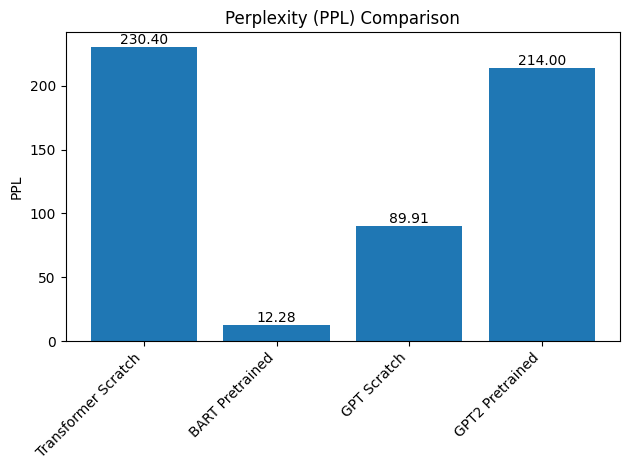

In [2]:
#PPL
#PPL = exp(Log-PPL) đo mức “bối rối” của model khi dự đoán chuỗi token; PPL thấp → model càng hiểu rõ phân phối ngôn ngữ.
plt.figure()
bars = plt.bar(models, ppl)
plt.title('Perplexity (PPL) Comparison')
plt.ylabel('PPL')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'{h:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Tr.scratch PPL quá cao -> khá tệ

- BART Pretrained có tỉ lệ PPL thấp nhất (12.3), cho thấy nó “hiểu” chuỗi y tế xuất sắc, nhờ pretraining và fine-tune tốt.

- GPT Scratch đứng thứ hai (89.9), tốt hơn hẳn GPT2 Pretrained (214.0) và Transformer Scratch (230.4).

---

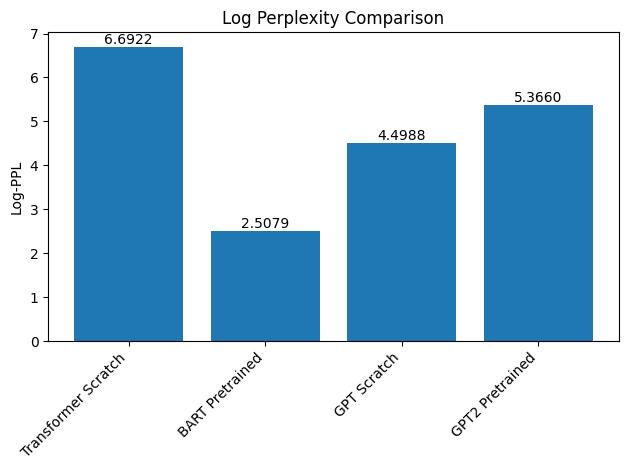

In [3]:
#Log-PPL
# Log-PPL (average negative log-likelihood) là bản gốc mà PPL lấy mũ, giúp so sánh tuyến tính hơn.
plt.figure()
bars = plt.bar(models, logppl)
plt.title('Log Perplexity Comparison')
plt.ylabel('Log-PPL')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'{h:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


- BART Pretrained (Log-PPL 2.51, PPL ~12) thể hiện khả năng “nắm” gần như toàn bộ cấu trúc và ngữ cảnh trong domain y tế chỉ sau 2 epoch fine-tune.

- GPT Scratch (Log-PPL 4.50, PPL ~90) cho thấy một decoder-only custom cũng có thể học khá nhanh từ đầu, nhưng vẫn thua BART do thiếu pretraining encoder–decoder mạnh.


- GPT2 Pretrained PPL rất cao (~214) dù BLEU/ROUGE kha khá, chứng tỏ mismatch ngôn ngữ: model sinh mượt nhưng “không quen” xác suất sequence y tế.

- Transformer Scratch kém nhất (PPL~230) là tín hiệu rõ ràng: học seq2seq từ đầu với ~100k mẫu không đủ để đạt chất lượng language modeling tốt.

---

---

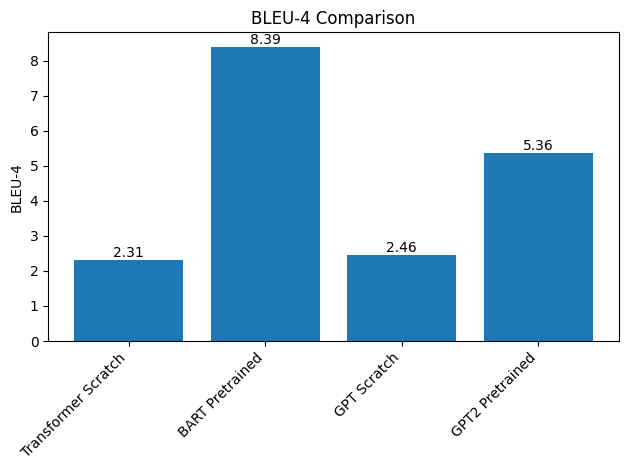

In [4]:
#BLEU-4, độ khớp ngặt nghèo của 4-gram output vs reference, phản ánh khả năng sinh chính xác các cụm từ dài.
plt.figure()
bars = plt.bar(models, bleu_scores)
plt.title('BLEU-4 Comparison')
plt.ylabel('BLEU-4')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'{h:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

- BART Pretrained dẫn rõ rệt, cho thấy output của nó chứa nhiều 4-gram trùng với reference—nhờ pretraining seq2seq tối ưu cho generation.

- GPT2 Pretrained xếp nhì (5.36), dù PPL cao, nhờ sampling/beam đưa model vào các n-gram quen thuộc.

- GPT Scratch và Transformer Scratch gần ngang nhau (~2.3–2.5), nhưng GPT Scratch vẫn nhỉnh hơn một chút nhờ toàn decoder tập trung generation.

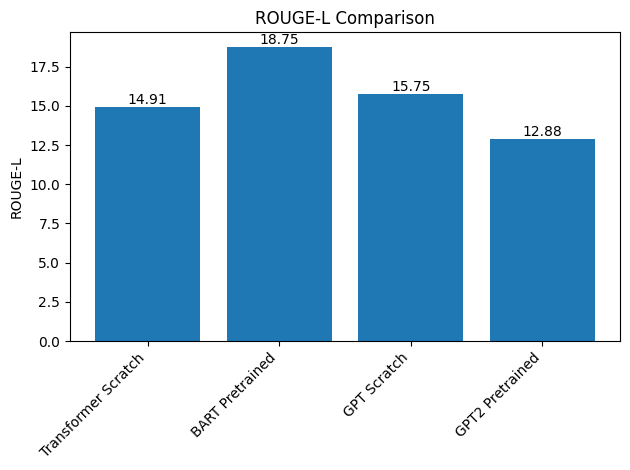

In [5]:
#ROUGE-L, tỷ lệ LCS (longest common subsequence) giữa output và reference, đánh giá độ khớp cấu trúc & ý chính.
plt.figure()
bars = plt.bar(models, rouge_scores)
plt.title('ROUGE-L Comparison')
plt.ylabel('ROUGE-L')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f'{h:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

- BART Pretrained cao nhất, càng khẳng định mô hình này nắm rõ topic và câu trả lời domain.

- Transformer Scratch (14.91) còn bất ngờ hơn GPT2 Pretrained (15.75) về LCS, dù BLEU rất thấp—chỉ ra rằng encoder–decoder từ đầu đôi khi vẫn bắt được cấu trúc dài mà greedy generation thiếu.

- GPT Scratch (12.88) xếp cuối, nhưng vẫn đạt mức “chấp nhận được” so với các scratch model khác.

- Decoder-only (GPT Scratch) dễ học generation nhưng khó đạt PPL thấp bằng encoder–decoder có memory đầy đủ.

- Encoder–decoder scratch nhận LCS khá tốt nhờ cross-attention nhưng BLEU quá thấp vì chưa học đủ n-gram.

---
---
---

# KẾT LUẬN

Đầu tiên là so sánh transformer với GPT
---
ta thấy,
- tại TRANSFORMER: khi train từ đầu thì khả năng generatiuon khá hạn chế. tuy nhiên khi dùng pretrained của facebook rồi finetune thì nó đạt kq rất tốt----> cho thấy mô hình nắm vững ngữ cảnh và sinh câu rất chính xác.
---

- tại GPT:  GPT từ đầu (scratch) dễ học generation hơn Transformer scratch, nhưng vẫn kém BART pretrained.

- GPT-2 pretrained tuy sinh câu trơn tru (bleu và rouge thấp) . tuy nhiên PPL khá cao (có thể do domain gap)


---

- Tiếp đến khi so pretrained với train từ đầu:
thông thường, Pretrained BART/GPT-2 cho hiệu suất vượt trội chỉ sau vài epoch fine-tune: BART-base nổi bật nhất, GPT-2 cũng cải thiện đáng kể so với scratch.

- Tuy nhiên, GPT scratch vẫn tốt hơn Transformer scratch vì decoder-only đơn giản, PPL và ROUGE-L đều vượt đáng kể.

---

=====> KẾT LUẬN: đối với bài toán mô hình tư vấn y tế, lựa chọn Transformer pretrained (BART fine-tune) là lựa chọn hàng đầu—vừa hiểu domain, vừa sinh câu chất lượng cao.
---
Nếu hạn chế về GPU, cũng có thể lựa GPT mpdel